# Experiments with Lomb Scargle for Unsupervised Classification

## Imports

In [1]:
import pickle
import umap

import matplotlib.pyplot as plt
import numpy as np

from umap import UMAP
from pyentrp import entropy as ent
from scipy.signal import lombscargle

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load ELAsTiCC data set

In [2]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [3]:
test_dir = "/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/processed/train"
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

## Loop through and compute the entropies

In [4]:
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 19
color_arr=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [21]:
filtered_classes = []
filtered_periodogram = []

for i in range(len(astrophysical_classes)):

    # Find the detections
    phot_flag = X_ts[i]['detection_flag']
    idx = np.where(phot_flag==1)[0]

    # Find the time series and rescale
    time = X_ts[i]['scaled_time_since_first_obs'].to_numpy()[idx] * 100
    flux = X_ts[i]['scaled_FLUXCAL'].to_numpy()[idx] * 1000

    # Time scale in days
    time_scales = 2**np.arange(0, 10, 1)

    #if len(idx) >= 30 and np.all(flux > 0) :
            
    periodogram = lombscargle(time, flux, time_scales)

    filtered_classes.append(astrophysical_classes[i])
    filtered_entropies.append(periodogram)

In [22]:
filtered_periodogram = np.array(filtered_periodogram)
filtered_classes = np.array(filtered_classes)

In [23]:
filtered_periodogram.shape

(0,)

In [14]:
inf_idx = np.where(filtered_periodogram==np.inf)[0]
filtered_periodogram[inf_idx] = 1000
# filtered_entropies = np.delete(filtered_entropies, inf_idx, axis=0)
# filtered_classes = np.delete(filtered_classes, inf_idx, axis=0)

In [15]:
nan_idx = np.where(np.isnan(filtered_periodogram))[0]
filtered_periodogram[nan_idx] = 0
# filtered_entropies = np.delete(filtered_entropies, nan_idx, axis=0)
# filtered_classes = np.delete(filtered_classes, nan_idx, axis=0)

In [17]:
filtered_periodogram.shape

(1081614, 6)

In [24]:
reducer = UMAP(random_state=42)
embedding = reducer.fit_transform(filtered_periodogram)
embedding.shape

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

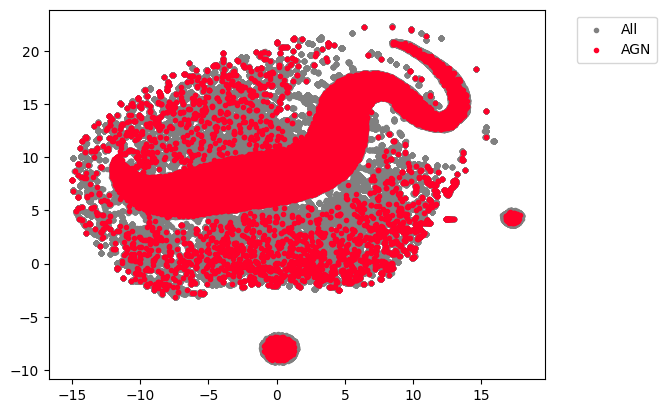

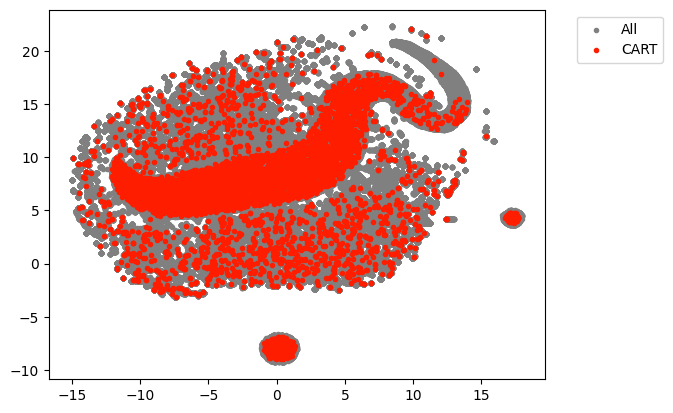

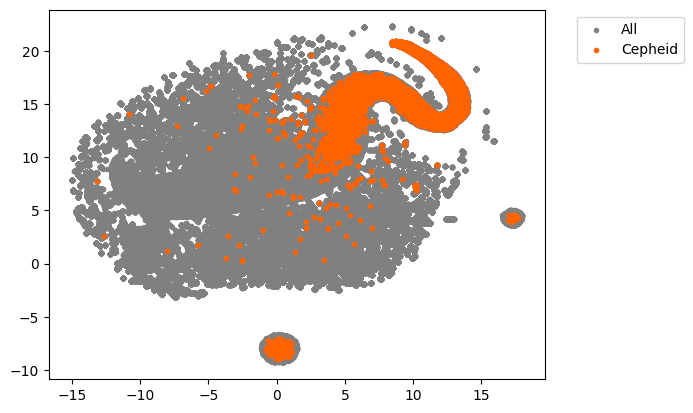

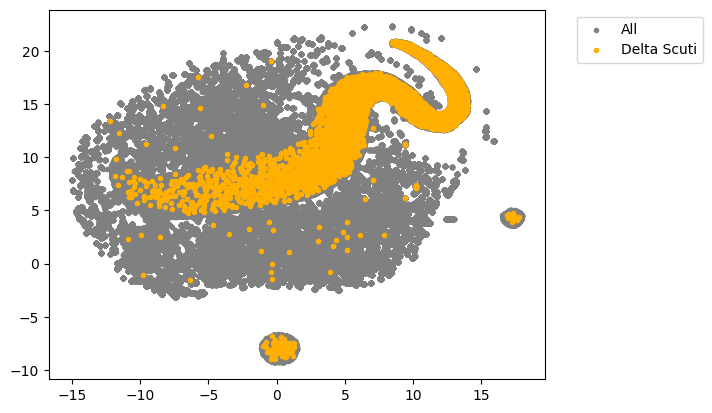

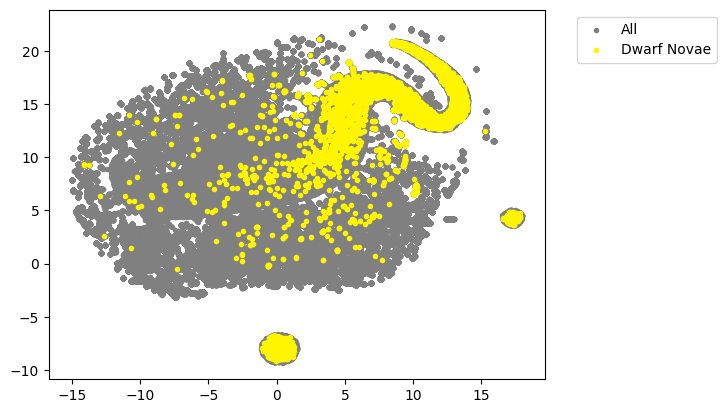

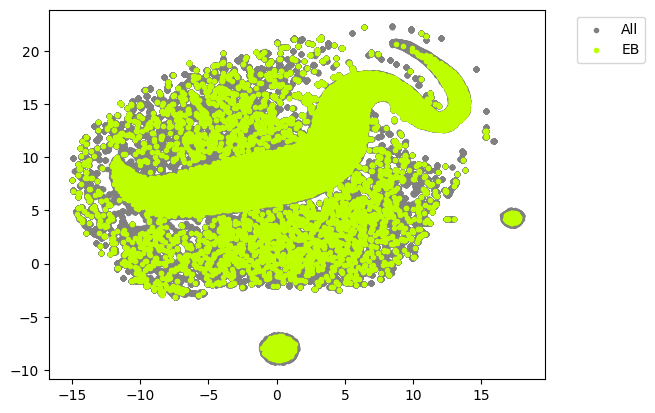

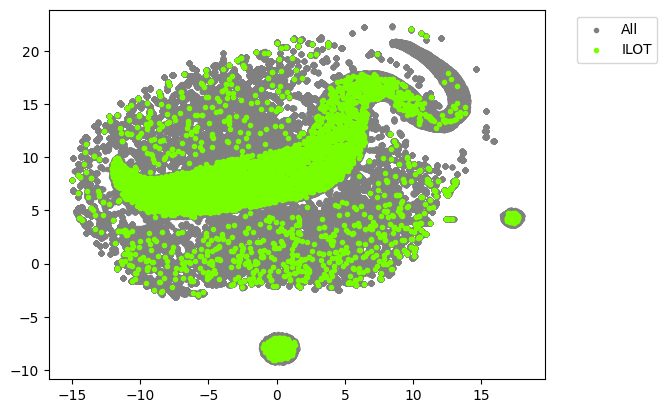

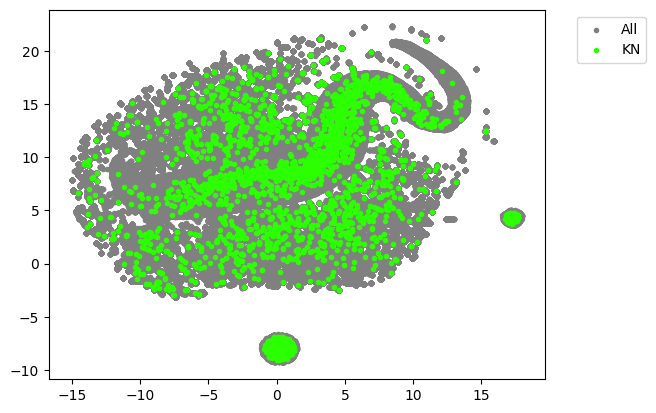

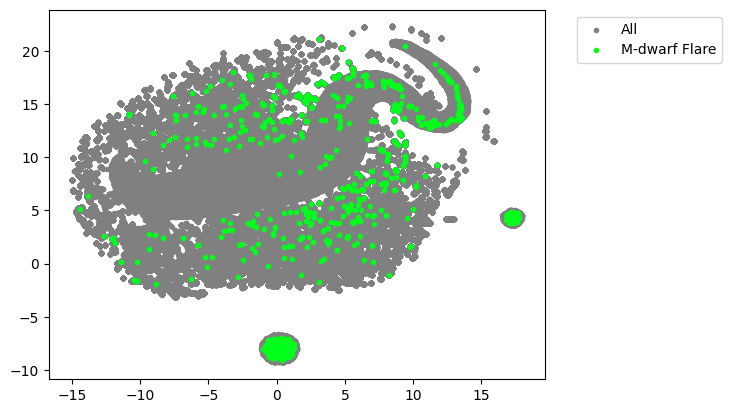

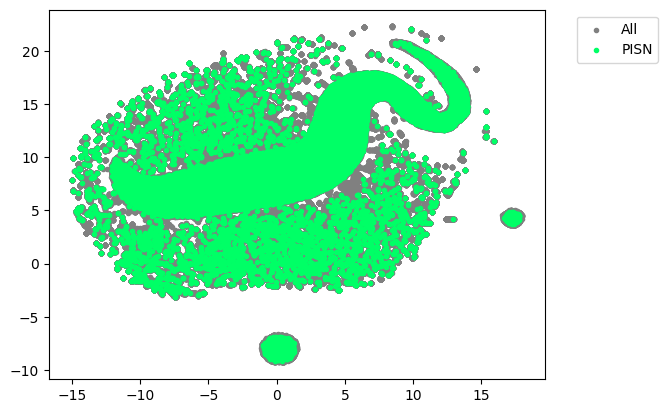

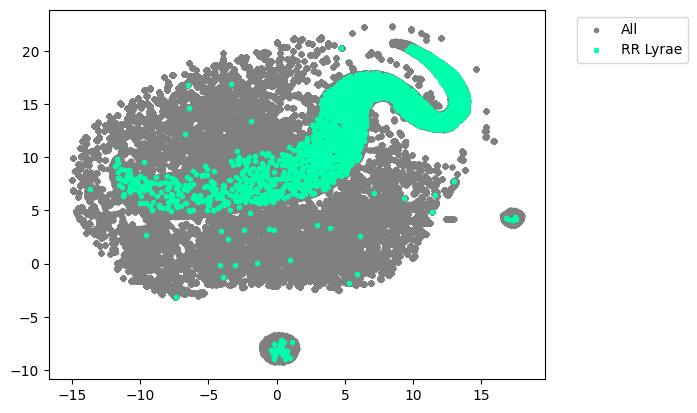

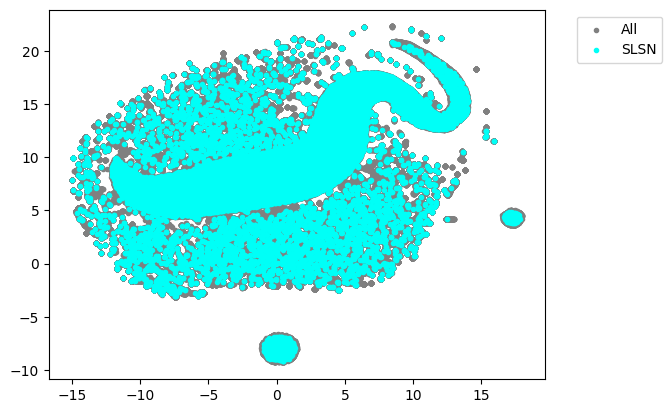

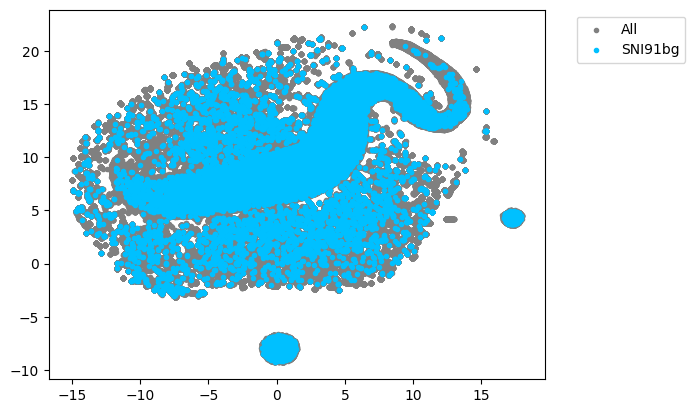

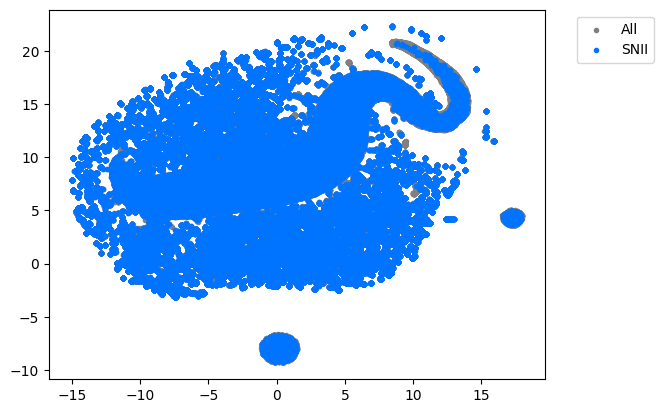

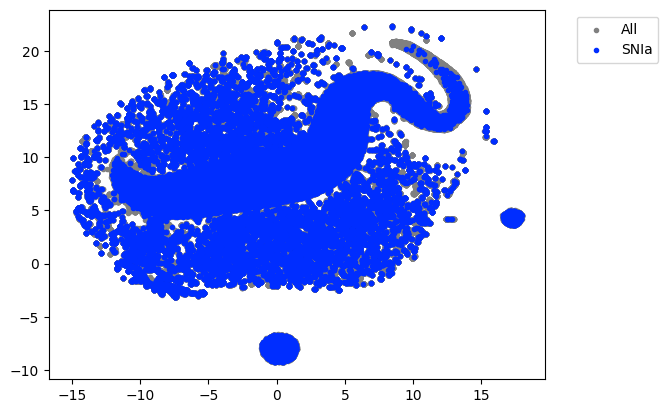

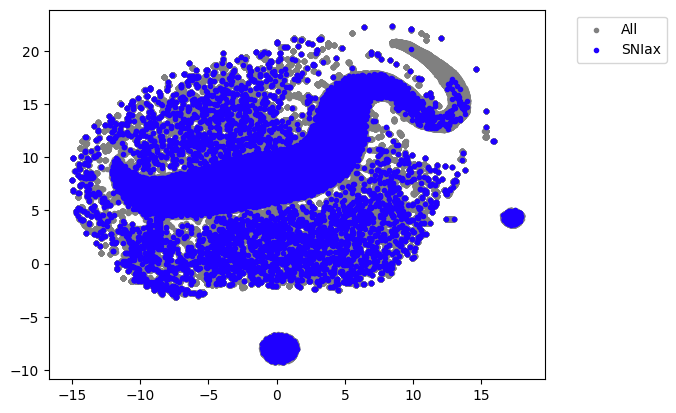

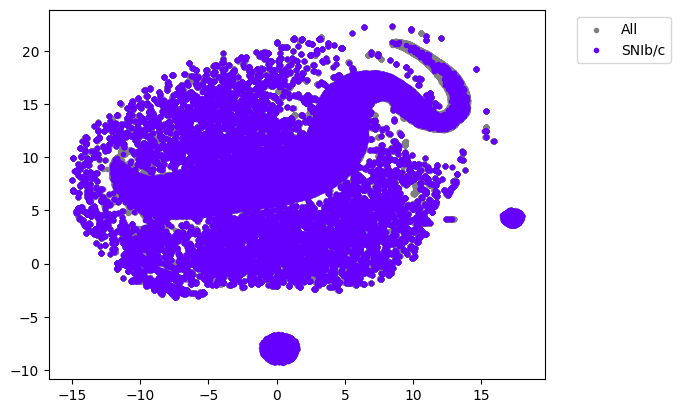

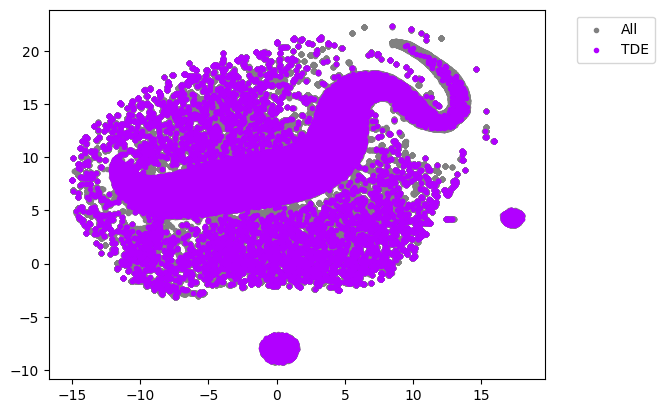

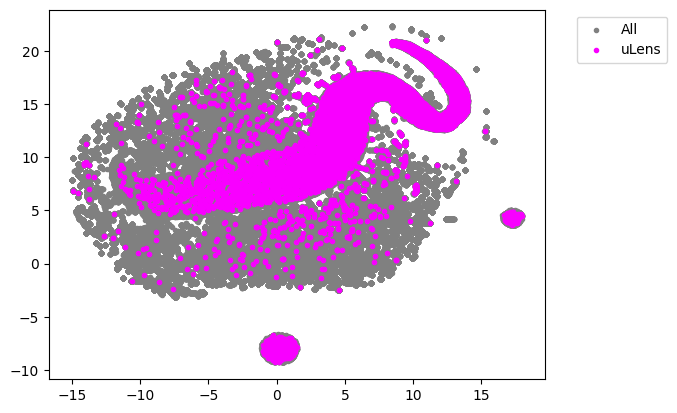

In [20]:

for i, c in enumerate(np.unique(filtered_classes)):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[:, 0], embedding[:, 1], label="All", marker='.', color='gray')
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', color=color_arr[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

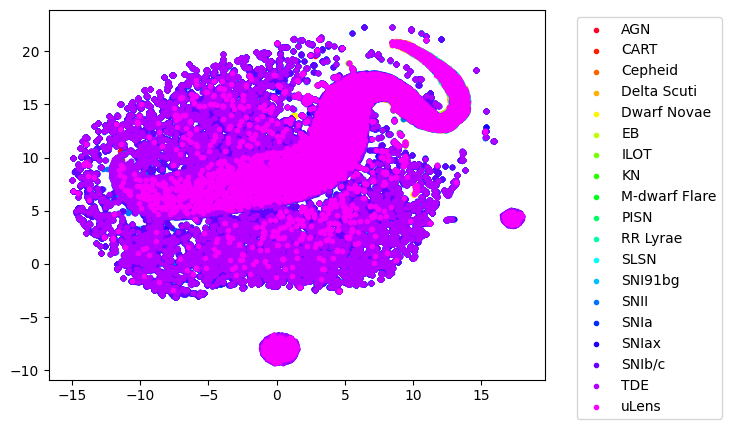

In [25]:
for i, c in enumerate(np.unique(filtered_classes)):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', color=color_arr[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


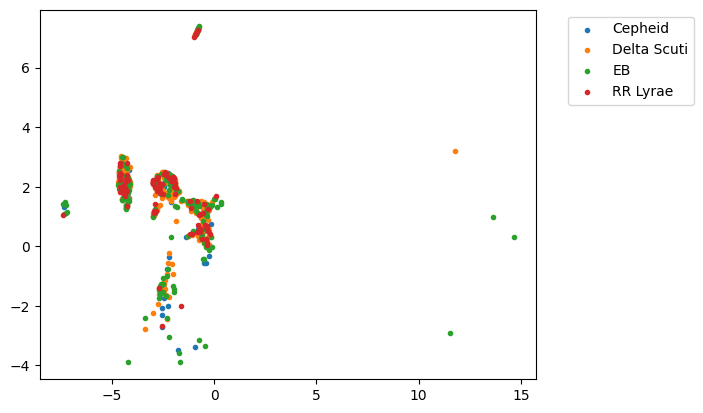

In [161]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

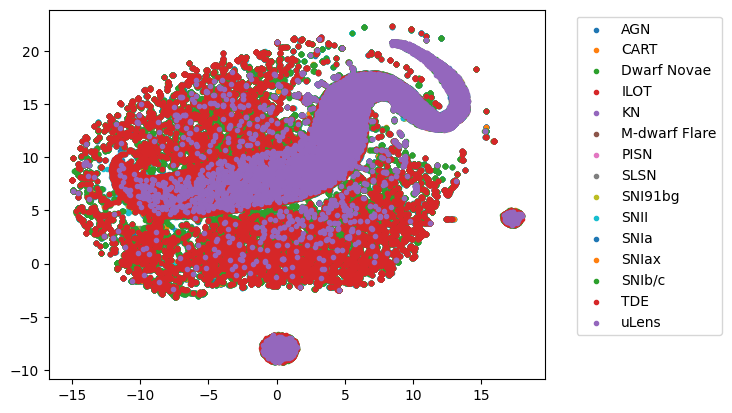

In [26]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c not in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

[-10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0]

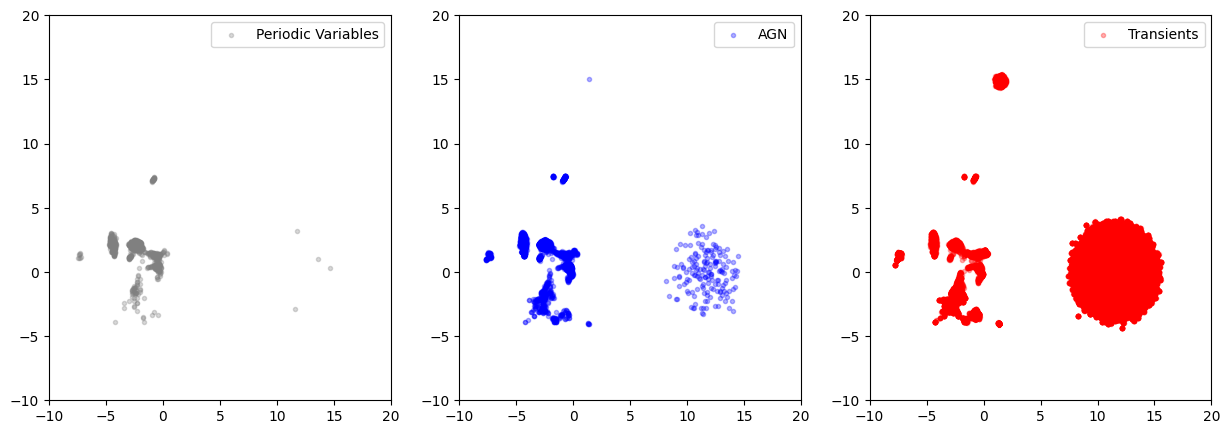

In [163]:
variables = []
agns = []
transients = []

for c in np.unique(filtered_classes):

    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        variables.append(embedding[idx, :])
        #axes[0].scatter(embedding[idx, 0], embedding[idx, 1], label="Periodic Variables", marker='.', color="gray", alpha=0.3)
    elif c == "AGN":
        agns.append(embedding[idx, :])
        #axes[1].scatter(embedding[idx, 0], embedding[idx, 1], label="AGN", marker='.', color="blue", alpha=0.3)
    else:
        transients.append(embedding[idx, :])
        #axes[2].scatter(embedding[idx, 0], embedding[idx, 1], label="Transients", marker='.', color="red", alpha=0.3)


variables = np.concatenate(variables)
agns = np.concatenate(agns)
transients = np.concatenate(transients)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


axes[0].scatter(variables[:, 0], variables[:, 1], label="Periodic Variables", marker='.', color="gray", alpha=0.3)
axes[1].scatter(agns[:, 0], agns[:, 1], label="AGN", marker='.', color="blue", alpha=0.3)
axes[2].scatter(transients[:, 0], transients[:, 1], label="Transients", marker='.', color="red", alpha=0.3)

axes[0].legend()
axes[1].legend()
axes[2].legend()

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-10, 20)
custom_ylim = (-10, 20)

# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)